<a href="https://colab.research.google.com/github/karynaur/supreme-CLIP/blob/rev_image_search/reverse%20img%20search/rev_image_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Reverse Image Search

##Download the dataset JSON 

In [ ]:
!gdown --id 1EvRZNlS0d41ngcSv1wxLSJCdZV27wzf2

Downloading...
From: https://drive.google.com/uc?id=1EvRZNlS0d41ngcSv1wxLSJCdZV27wzf2
To: /content/data.json
100% 455M/455M [00:02<00:00, 158MB/s]


##Install CLIP

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ht8qwf4n
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-ht8qwf4n
     |████████████████████████████████| 64 kB 2.9 MB/s 
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369090 sha256=672829ff61278f36fbf9adc1570c07cb805bf5783b180e2c76a86d24cf47148d
  Stored in directory: /tmp/pip-ephem-wheel-cache-gmlyc3h5/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=39c733154927731d0c9e5bfa90f4646bacbe1575c290d092e5176b1059f7891a
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built clip ftfy


##Preprocess Data

In [ ]:
import json 
import torch

with open('data.json', 'r') as f:
    data = json.loads(f.read())

In [ ]:
def preprocess_data(data):
    image_embd = [] #to store all CLIP embeddings
    for i in data.keys():
        data[i]['image_features'] = torch.tensor(list(map(float,data[i]['image_features'][0])), dtype = torch.float).unsqueeze(0)
        image_embd.append(data[i]['image_features'])
    image_embd = torch.cat(image_embd)
    image_embd /= image_embd.norm(dim = -1, keepdim=True) #normalize
    keys = list(data.keys()) #collect keys
    print(f"There are {len(keys)} no. of image embeddings of size {image_embd.shape}")
    return data, keys, image_embd # preprocessed data, list of keys and image embeddings tensor

In [ ]:
data, keys, image_embd = preprocess_data(data)

There are 24990 no. of image embeddings of size torch.Size([24990, 512])


##Model initialization

In [ ]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
image_embd = image_embd.to(device)


##User input Image

In [ ]:
#@title Upload Image

import ipywidgets as widgets

btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

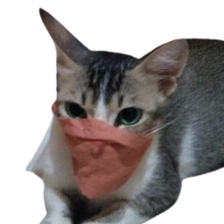

In [ ]:
from PIL import Image
import io

img = Image.open(io.BytesIO(btn_upload.data[-1])).resize((224, 224))
img

##Define Similarity Function

In [ ]:
import numpy as np

def get_sim(img):
    with torch.inference_mode():
        image = preprocess(img).unsqueeze(0).to(device)
        input_features = model.encode_image(image).float()
        input_features /= input_features.norm(dim=-1, keepdim=True)
       

        logit_scale = 100 
        logits= (logit_scale * image_embd @ input_features.t()).squeeze()
        logits = logits.cpu().numpy()
        best_photo_idx = np.argsort(logits)[::-1]
        best_photos = [(logits[i],i) for i in best_photo_idx]
    return best_photos #return Best matched photos

In [ ]:
best_photos = get_sim(img)

##Display the images

In [ ]:
#@title String fields

num = 16 #@param {type:"integer"}

print(f"You would like to see {num} similar images")


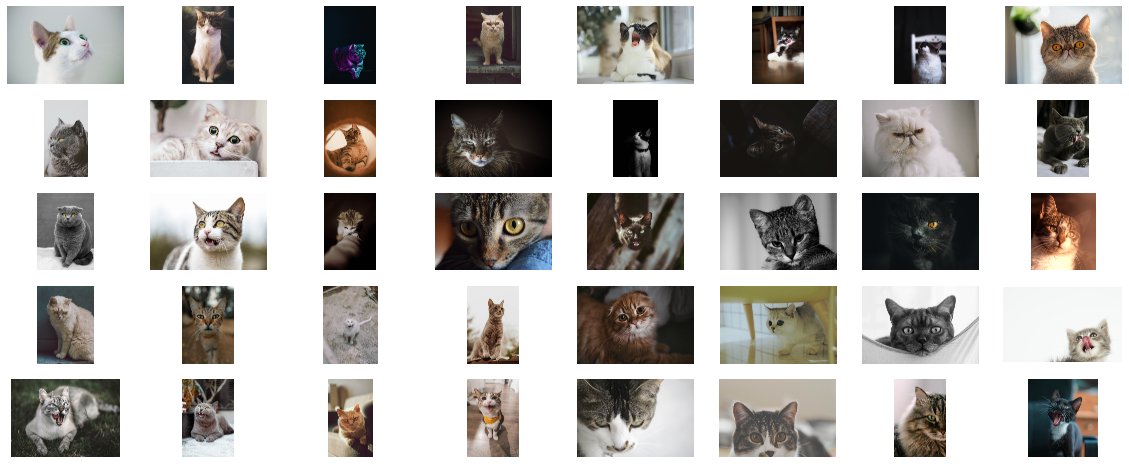

In [ ]:
import urllib
import matplotlib.pyplot as plt


ncol = 8
nrow = num // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(num):
    url = data[keys[best_photos[i][1]]]['image_url']
    plt.subplot(nrow, ncol, i+1)
    image = Image.open(urllib.request.urlopen(url))
    plt.imshow(image)
    plt.axis('off')